In [ ]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import os
import torch
from PIL import Image

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Part 1: Detect Hands in the First Frame

I have to write code that can output information on hand location(s) in an image. My goal is to return an output that can be used as a SAM 2 prompt (e.g., clicks, bounding boxes). I will use hand landmarks output from `mediapipe` which will be used a positive prompts for SAM 2 later as a part of Part 2.

First frame loaded successfully.


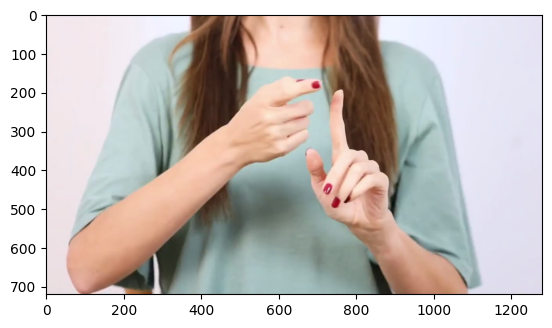

In [ ]:
try:
    video_path = "hand/test.mp4"
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise FileNotFoundError(f"Error: Could not open video file '{video_path}'.")

    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        raise ValueError("Error: Could not read the first frame.")

    print("First frame loaded successfully.")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [3]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [4]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5
)

I0000 00:00:1739693315.548875 4300202 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3


In [5]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

results = hands.process(frame_rgb)

if results.multi_hand_landmarks:
    print(f"Detected {len(results.multi_hand_landmarks)} hand(s).")
else:
    print("No hands detected.")

Detected 2 hand(s).


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1739693315.561002 4300415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739693315.567017 4300411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739693315.585260 4300415 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [19]:
hand_keypoints = []

if results.multi_hand_landmarks:
    height, width, _ = frame.shape

    for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        for landmark in hand_landmarks.landmark:
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            hand_keypoints.append((x, y))

print(hand_keypoints)

[(487, 335), (500, 267), (551, 207), (609, 183), (650, 196), (550, 226), (619, 200), (662, 187), (695, 183), (566, 271), (670, 242), (662, 238), (637, 243), (584, 313), (670, 279), (654, 272), (628, 277), (599, 351), (667, 312), (653, 303), (630, 309), (806, 534), (751, 510), (711, 455), (696, 408), (688, 366), (759, 369), (748, 297), (748, 250), (750, 211), (804, 371), (772, 367), (745, 419), (731, 459), (840, 392), (799, 402), (770, 447), (755, 479), (866, 423), (830, 428), (801, 455), (785, 475)]


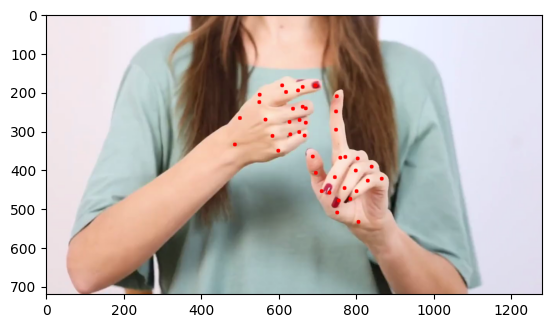

In [7]:
annotated_frame = frame.copy()

for hand in hand_keypoints:
    for x, y in hand:
        cv2.circle(annotated_frame, (x, y), 5, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.show()

# Part 2: Use Part 1 and SAM 2 to Track Hands

Now, I am supposed to write a function that uses SAM 2 and the results from Part 1 to generate masks for every frame of the video.
The results from Part 1 have to be the input prompts into SAM 2. Ideally, the parameters of this function should be an input and output path. The function will write a new video with the masks to the output path.

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: mps


In [9]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [23]:
def show_mask(mask, ax, obj_id=None, random_color=False, img_size=(720, 1280)):
    """Fixes mask size and applies a red mask with transparency"""
    
    # Force RED color: [R, G, B, Alpha]
    color = np.array([1.0, 0.0, 0.0, 0.6])  # Red with 60% transparency

    # Ensure mask is 2D
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]  # Convert (1, H, W) → (H, W)
    
    # Resize mask to match frame size
    h, w = img_size
    mask_resized = cv2.resize(mask.astype(np.uint8) * 255, (w, h), interpolation=cv2.INTER_NEAREST)
    
    # Apply red color to mask
    mask_color = np.zeros((h, w, 4))  # RGBA
    mask_color[..., :3] = color[:3]  # Set RGB to red
    mask_color[..., 3] = (mask_resized > 0).astype(np.float32) * color[3]  # Apply alpha
    
    ax.imshow(mask_color)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


In [11]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [12]:
def show_mask(mask, ax, obj_id=None, random_color=False, img_size=(720, 1280)):
    """Fixes mask size and color blending"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id % 10
        color = np.array([*cmap(cmap_idx)[:3], 0.6])

    # Ensure mask is 2D
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]  # Convert (1, H, W) → (H, W)
    
    # Resize mask to match frame size
    h, w = img_size
    mask_resized = cv2.resize(mask.astype(np.uint8) * 255, (w, h), interpolation=cv2.INTER_NEAREST)
    
    # Normalize and apply color
    mask_color = np.zeros((h, w, 4))  # RGBA
    mask_color[..., :3] = color[:3]  # RGB color
    mask_color[..., 3] = (mask_resized > 0).astype(np.float32) * color[3]  # Alpha
    
    ax.imshow(mask_color)

In [13]:
!ffmpeg -i hand/test.mp4 -q:v 2 -start_number 0 frames/%05d.jpg

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

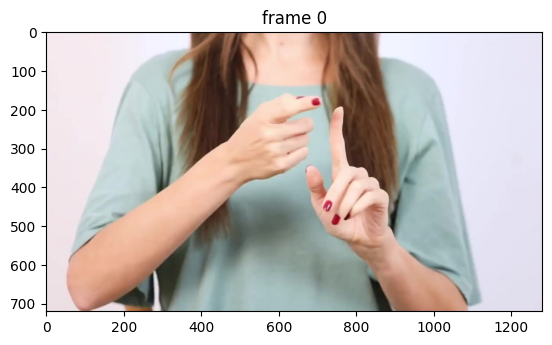

In [14]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [15]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|███████████████████| 210/210 [00:03<00:00, 52.92it/s]


In [16]:
predictor.reset_state(inference_state)

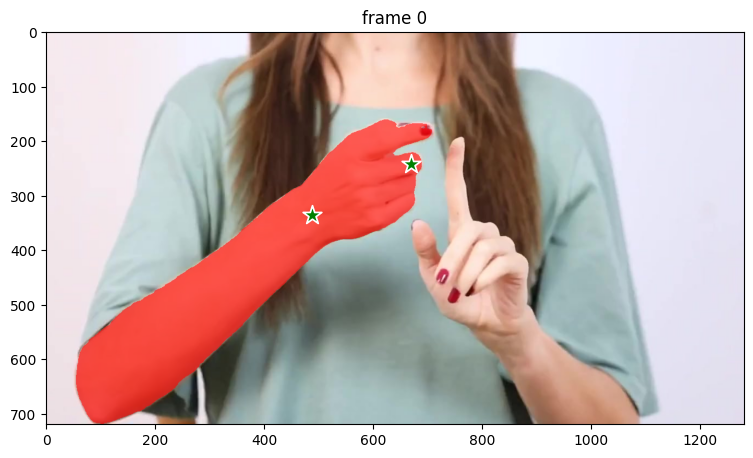

In [27]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([hand_keypoints[0], hand_keypoints[10]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0][0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

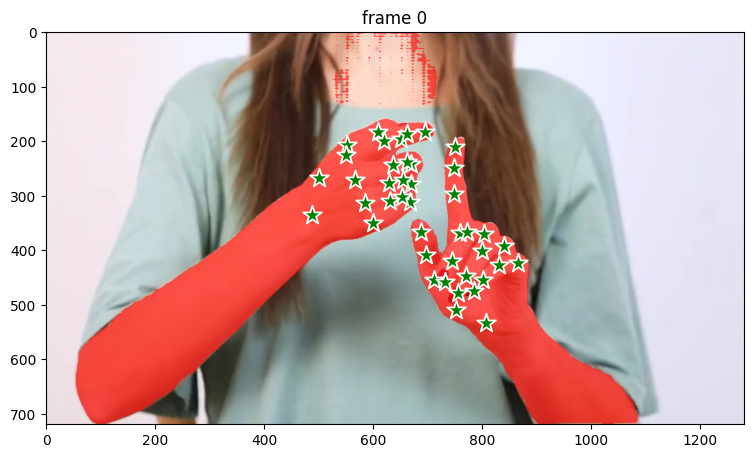

In [32]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array(hand_keypoints, dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1 for _ in range(len(hand_keypoints))], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0][0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [33]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|█████████████████████| 210/210 [07:00<00:00,  2.00s/it]


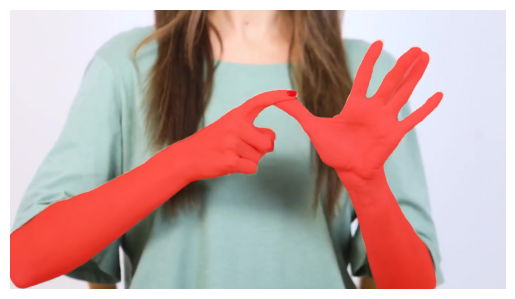

In [62]:
for out_frame_idx in range(0, len(frame_names)):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        plt.axis(False)
        show_mask(out_mask.squeeze(), plt.gca(), obj_id=out_obj_id)
        plt.savefig(f'sample{out_frame_idx}.jpg', bbox_inches="tight", pad_inches=0, dpi=300)

In [65]:
!ffmpeg -y -framerate 30 -i sample%d.jpg -vf "scale=1488:838,setsar=1:1" -c:v libx264 -preset medium -crf 23 -pix_fmt yuv420p -movflags +faststart output.mp4

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e